In [1]:
import numpy as np
import xarray as xr
from sklearn.cluster import KMeans
import yaml

In [2]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import colorcet as cc

from utils import plot_field

In [3]:
config_path = "/n/home12/mhe/integrated_methane_inversion/config.harvard-cannon.global_inv.yml"
land_cover_pth = "/n/holyscratch01/external_repos/GEOS-CHEM/gcgrid/gcdata/ExtData/GEOS_2x2.5/GEOS_FP/2011/01/GEOSFP.20110101.CN.2x25.nc"

# Get config
config = yaml.load(open(config_path), Loader=yaml.FullLoader)
lat_min = config["LatMin"]
lat_max = config["LatMax"]
lon_min = config["LonMin"]
lon_max = config["LonMax"]
is_regional=config["isRegional"]
buffer_deg = config["BufferDeg"]
land_threshold = config["LandThreshold"]
emis_threshold = config["OffshoreEmisThreshold"]
k_buffer_clust = config["nBufferClusters"]

lc = xr.load_dataset(land_cover_pth)

In [5]:
ice = lc.where(lc["FRLANDIC"] < 0.5).drop("time").squeeze()
print(ice)

degx = 4 * 2.5
degy = 4 * 2.0

lon_bounds = [np.min(lc.lon.values)+degx, np.max(lc.lon.values)-degx]
lat_bounds = [np.min(lc.lat.values)+degy, np.max(lc.lat.values)-degy]

print(lon_bounds, lat_bounds)

<xarray.Dataset>
Dimensions:   (lat: 91, lon: 144)
Coordinates:
  * lat       (lat) float32 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon       (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Data variables:
    FRLAKE    (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    FRLAND    (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    FRLANDIC  (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    FROCEAN   (lat, lon) float32 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    PHIS      (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Title:                 GEOS-FP constant parameters (CN), processed for GE...
    Contact:               GEOS-Chem Support Team (geos-chem-support@as.harva...
    References:            www.geos-chem.org; wiki.geos-chem.org
    Filename:              GEOSFP.20110101.CN.2x25.nc
    ProductionDateTime:    File generated on: 2014/01/13 15:18:46 GM

In [6]:
ice["FRLANDIC"].max()

<xarray.DataArray 'FRLANDIC' ()>
array(0.49336636)

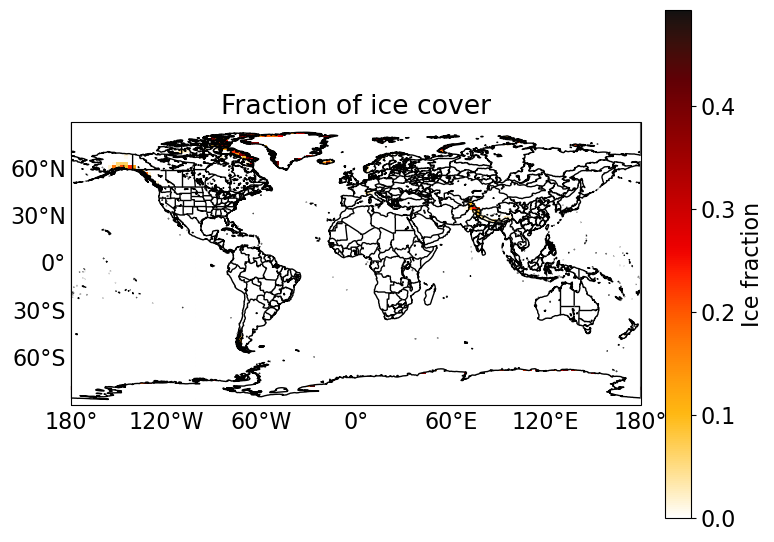

In [7]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ice["FRLANDIC"], cmap=cc.cm.linear_kryw_5_100_c67_r, 
           title='Fraction of ice cover', cbar_label='Ice fraction')

In [8]:
lc = (lc["FRLAKE"] + lc["FRLAND"] + lc["FRLANDIC"].where(lc["FRLANDIC"] < 0.5,drop=True)).drop("time").squeeze()
print(lc[78,:])

<xarray.DataArray (lon: 144)>
array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.5932778e-05,
       6.5605074e-02, 2.0233162e-01, 1.2671268e-01, 3.5721913e-01,
       3.1159040e-01, 1.7281132e-02, 2.2048318e-01, 3.8339183e-01,
       3.2485935e-01, 3.0164352e-01, 3.7239921e-01, 3.2894486e-01,
       4.7464254e-01, 5.8973032e-01, 8.2656658e-01, 9.3084753e-01,
                 nan,           nan, 2.1094301e-01, 2.3788103e-01,
       7.0272911e-01,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           

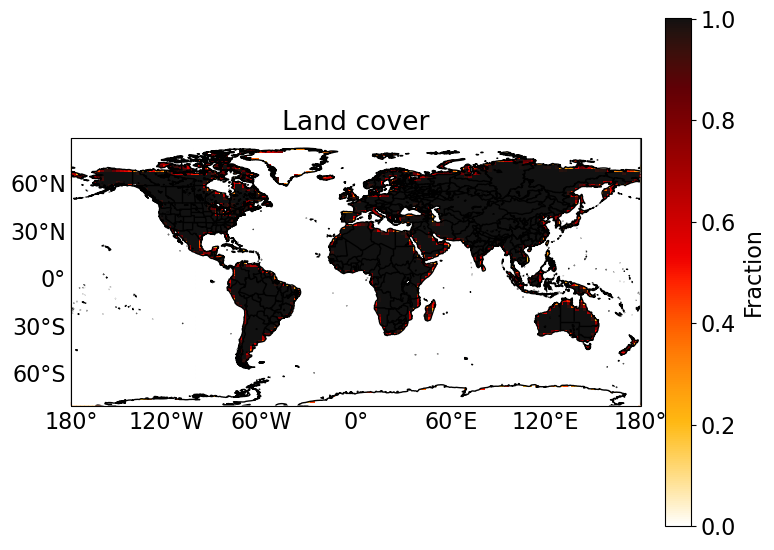

In [9]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, lc, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           title='Land cover', cbar_label='Fraction')

In [ ]:
lc

In [10]:
lc_df = lc.to_dataframe(name='lc').dropna(how='all')
lc_df

lc
lat   lon             
-78.0 -180.0  0.367953
      -177.5  0.300740
      -175.0  0.284859
      -172.5  0.264678
      -170.0  0.261205
...                ...
 90.0  167.5  0.000000
       170.0  0.000000
       172.5  0.000000
       175.0  0.000000
       177.5  0.000000

[11561 rows x 1 columns]

In [ ]:
# ignore, repopulates with nans where they were just removed

lc_darray = lc_df.to_xarray()
lc_xarray = lc_darray.to_array()
lc_xarray

In [11]:
# initialize state vector
statevector = lc_df.where(lc_df == -9999.0)
statevector

lc
lat   lon       
-78.0 -180.0 NaN
      -177.5 NaN
      -175.0 NaN
      -172.5 NaN
      -170.0 NaN
...           ..
 90.0  167.5 NaN
       170.0 NaN
       172.5 NaN
       175.0 NaN
       177.5 NaN

[11561 rows x 1 columns]

In [12]:
statevector['lc'] = np.arange(1, 11562)[::-1]

In [ ]:
print(statevector.isnull().sum()[0] + 1)

In [13]:
statevector

lc
lat   lon          
-78.0 -180.0  11561
      -177.5  11560
      -175.0  11559
      -172.5  11558
      -170.0  11557
...             ...
 90.0  167.5      5
       170.0      4
       172.5      3
       175.0      2
       177.5      1

[11561 rows x 1 columns]

In [14]:
statevector_xarray = statevector.to_xarray()
statevector_xarray = statevector_xarray.to_array()
statevector_xarray = statevector_xarray.drop("variable").squeeze()
print(statevector_xarray)

<xarray.DataArray (lat: 85, lon: 144)>
array([[1.1561e+04, 1.1560e+04, 1.1559e+04, ...,        nan,        nan,
               nan],
       [1.1553e+04, 1.1552e+04, 1.1551e+04, ..., 1.1524e+04, 1.1523e+04,
        1.1522e+04],
       [1.1521e+04, 1.1520e+04, 1.1519e+04, ..., 1.1477e+04, 1.1476e+04,
        1.1475e+04],
       ...,
       [4.3200e+02, 4.3100e+02, 4.3000e+02, ..., 2.9100e+02, 2.9000e+02,
        2.8900e+02],
       [2.8800e+02, 2.8700e+02, 2.8600e+02, ..., 1.4700e+02, 1.4600e+02,
        1.4500e+02],
       [1.4400e+02, 1.4300e+02, 1.4200e+02, ..., 3.0000e+00, 2.0000e+00,
        1.0000e+00]])
Coordinates:
  * lat      (lat) float64 -78.0 -76.0 -74.0 -72.0 -70.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5


In [16]:
land = statevector_xarray.where(statevector_xarray > 0.25)
land

<xarray.DataArray (lat: 85, lon: 144)>
array([[1.1561e+04, 1.1560e+04, 1.1559e+04, ...,        nan,        nan,
               nan],
       [1.1553e+04, 1.1552e+04, 1.1551e+04, ..., 1.1524e+04, 1.1523e+04,
        1.1522e+04],
       [1.1521e+04, 1.1520e+04, 1.1519e+04, ..., 1.1477e+04, 1.1476e+04,
        1.1475e+04],
       ...,
       [4.3200e+02, 4.3100e+02, 4.3000e+02, ..., 2.9100e+02, 2.9000e+02,
        2.8900e+02],
       [2.8800e+02, 2.8700e+02, 2.8600e+02, ..., 1.4700e+02, 1.4600e+02,
        1.4500e+02],
       [1.4400e+02, 1.4300e+02, 1.4200e+02, ..., 3.0000e+00, 2.0000e+00,
        1.0000e+00]])
Coordinates:
  * lat      (lat) float64 -78.0 -76.0 -74.0 -72.0 -70.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

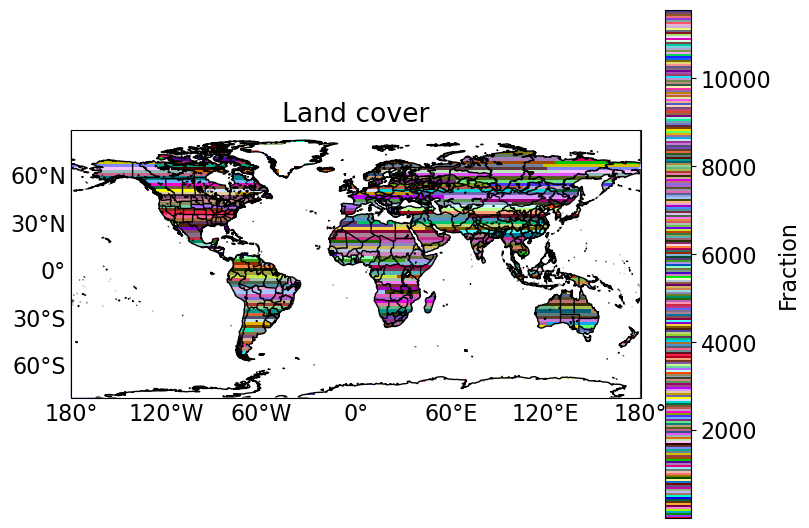

In [17]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, land, cmap=cc.cm.glasbey, 
           title='Land cover', cbar_label='Fraction')

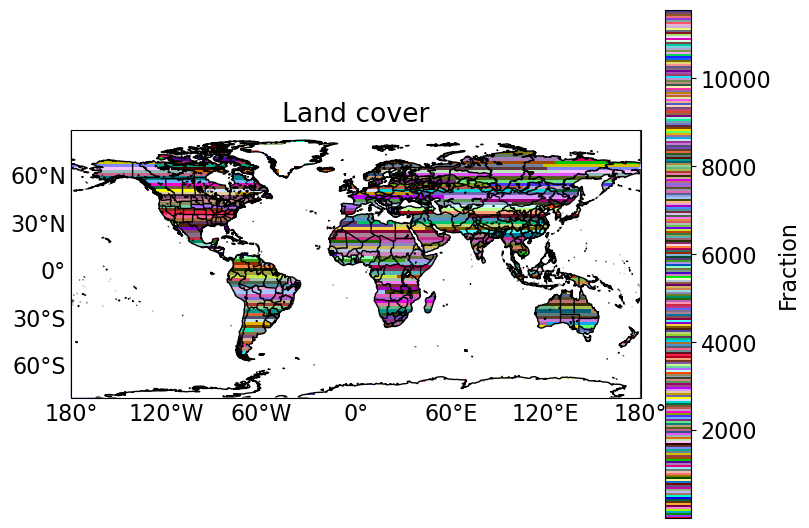

In [20]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, statevector_xarray, cmap=cc.cm.glasbey, 
           title='Land cover', cbar_label='Fraction')

In [ ]:
sv = None
sv["StateVector"] = sv["StateVector"].values[lc["FRLANDIC"].values < 0.5]
sv.values[lc["FRLANDIC"].values < 0.5]

# make base state vector file with native elements
# have reduced code point to that each time